The goal is to build models capable of predicting the following to find out what a screenplay can predict:
- Rating
- Year (Era of Cinema)
- Runtime
- IMDB Score
- Rotten Tomatoes
- Metascore
- Boxoffice
- Season
- Total Wins
- Total Noms
- Genres
- Country


In [1]:
# Packages For Whole Script
import pandas as pd
import os
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Movie Dataset
movie_data = pd.read_csv("movie_data_no_dummies.csv", index_col=[0])
movie_data.isna().sum()

title                0
OMDB_Title           0
Rating              14
Runtime              0
Genre                0
Director             0
Writer               0
Language             1
Country              1
IMDB                 2
IMDB_Votes           2
Rotten_Tomatoes     52
Metascore           89
Boxoffice           93
Day_of_Year          5
Week_of_Year         5
Season               5
Month                5
Year                 5
Total_Wins         220
Total_Noms         102
dtype: int64

In [3]:
# Transformer Model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

def read_text_file(title):
    file_path = os.path.join("Scripts", f"{title}.txt")
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            return text
    except FileNotFoundError:
        return None

objects_to_keep = ["accuracy", "data_collator", "movie_data", "tokenizer", "read_text_file", "objects_to_keep"]

# Rating Model

In [4]:
ratings = movie_data[["title", "Rating"]]
ratings["Rating"].value_counts()

R            608
PG-13        306
PG           127
Not Rated     23
Passed        16
G             15
Approved       9
NC-17          5
TV-MA          1
TV-14          1
M/PG           1
X              1
Unrated        1
18+            1
Name: Rating, dtype: int64

In [5]:
ratings = ratings[ratings["Rating"].isin(["G", "PG", "PG-13", "R"])].reset_index(drop=True)

In [6]:
ratings['text'] = ratings['title'].apply(read_text_file)

ratings = ratings.rename(columns={'Rating': 'label'})
ratings.head()

,title,label,text
0,10 Things I Hate About You,PG-13,TEN THINGS I HA...
1,12 and Holding,R,\n \n \n ...
2,12 Monkeys,R,TWELVE MONKEYS\n \n An orig...
3,12 Years a Slave,R,12 YEARS A SLAVE\...
4,127 Hours,R,\n 127 HOUR...


In [7]:
ratings_id2label = {0: "G", 1: "PG", 2: "PG-13", 3: "R"}
ratings_label2id = {"G": 0, "PG": 1, "PG-13": 2, "R": 3}

ratings['label'] = ratings['label'].map(ratings_label2id)

ratings = ratings.drop(columns="title")
ratings.head()

,label,text
0,2,TEN THINGS I HA...
1,3,\n \n \n ...
2,3,TWELVE MONKEYS\n \n An orig...
3,3,12 YEARS A SLAVE\...
4,3,\n 127 HOUR...


In [8]:
ratings_dataset = Dataset.from_pandas(ratings) 
ratings_dataset = ratings_dataset.train_test_split(test_size=0.2)

In [9]:
tokenized_ratings = ratings_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

In [10]:
ratings_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=ratings_id2label, label2id=ratings_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
ratings_training_args = TrainingArguments(
    output_dir="ratings_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

ratings_trainer = Trainer(
    model=ratings_model,
    args=ratings_training_args,
    train_dataset=tokenized_ratings["train"],
    eval_dataset=tokenized_ratings["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

ratings_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.9890871047973633, 'eval_accuracy': 0.5707547169811321, 'eval_runtime': 31.5036, 'eval_samples_per_second': 6.729, 'eval_steps_per_second': 0.444, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.9219452738761902, 'eval_accuracy': 0.5754716981132075, 'eval_runtime': 32.2963, 'eval_samples_per_second': 6.564, 'eval_steps_per_second': 0.433, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.9014900922775269, 'eval_accuracy': 0.5801886792452831, 'eval_runtime': 33.5461, 'eval_samples_per_second': 6.32, 'eval_steps_per_second': 0.417, 'epoch': 3.0}
{'train_runtime': 1634.2405, 'train_samples_per_second': 1.549, 'train_steps_per_second': 0.097, 'train_loss': 0.9498770851759041, 'epoch': 3.0}


TrainOutput(global_step=159, training_loss=0.9498770851759041, metrics={'train_runtime': 1634.2405, 'train_samples_per_second': 1.549, 'train_steps_per_second': 0.097, 'train_loss': 0.9498770851759041, 'epoch': 3.0})

In [12]:
ratings_trainer.save_model()

# Eras of Cinema

http://www.historyoffilm.net/movie-eras/history-of-cinema/

1927-1940 Talkies

1941-1954 Golden Era

1955-1976 The Changes

1977-1998 Dawn of Modern Film

1999-2024 New Millennium

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_62662/582954515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eras.dropna(inplace=True)


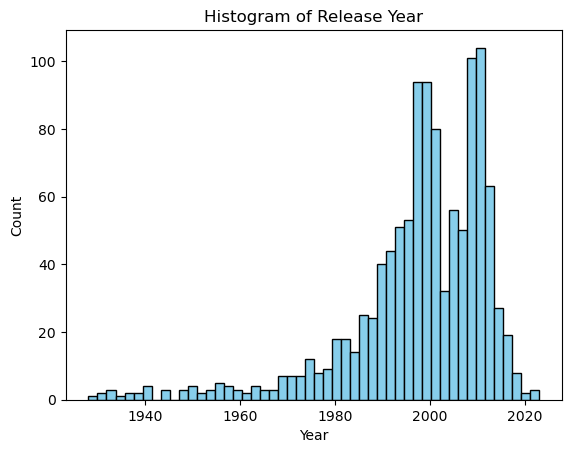

In [13]:
eras = movie_data[["title", "Year"]]

eras.dropna(inplace=True)

eras = eras.reset_index(drop=True)

plt.hist(eras["Year"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Histogram of Release Year')
plt.show()

In [14]:
bins = [1927, 1941, 1955, 1977, 1999, 2025]
labels = ['Talkies', 'Golden Era', 'The Changes', 'Dawn of Modern Film', 'New Millennium']
eras['label'] = pd.cut(eras['Year'], bins=bins, labels=labels, right=False)
eras["label"].value_counts()

New Millennium         639
Dawn of Modern Film    392
The Changes             63
Golden Era              17
Talkies                 13
Name: label, dtype: int64

In [15]:
eras['text'] = eras['title'].apply(read_text_file)

eras = eras.drop(columns="Year")

eras.head()

,title,label,text
0,10 Things I Hate About You,New Millennium,TEN THINGS I HA...
1,12,New Millennium,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...
2,12 and Holding,New Millennium,\n \n \n ...
3,12 Monkeys,Dawn of Modern Film,TWELVE MONKEYS\n \n An orig...
4,12 Years a Slave,New Millennium,12 YEARS A SLAVE\...


In [16]:
eras_id2label = {0: "Talkies", 1: "Golden Era", 2: "The Changes", 3: "Dawn of Modern Film", 4: "New Millennium"}
eras_label2id = {"Talkies": 0, "Golden Era": 1, "The Changes": 2, "Dawn of Modern Film": 3, "New Millennium": 4}

eras['label'] = eras['label'].map(eras_label2id)
eras["label"] = eras["label"].astype(int)

eras = eras.drop(columns="title")

In [17]:
eras_dataset = Dataset.from_pandas(eras) 
eras_dataset = eras_dataset.train_test_split(test_size=0.2)

In [18]:
tokenized_eras = eras_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/899 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

In [19]:
eras_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=5, id2label=eras_id2label, label2id=eras_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
eras_training_args = TrainingArguments(
    output_dir="eras_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

eras_trainer = Trainer(
    model=eras_model,
    args=eras_training_args,
    train_dataset=tokenized_eras["train"],
    eval_dataset=tokenized_eras["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

eras_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.1091399192810059, 'eval_accuracy': 0.47555555555555556, 'eval_runtime': 37.7411, 'eval_samples_per_second': 5.962, 'eval_steps_per_second': 0.397, 'epoch': 1.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.0421574115753174, 'eval_accuracy': 0.5155555555555555, 'eval_runtime': 38.7133, 'eval_samples_per_second': 5.812, 'eval_steps_per_second': 0.387, 'epoch': 2.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.9617574214935303, 'eval_accuracy': 0.6044444444444445, 'eval_runtime': 38.8998, 'eval_samples_per_second': 5.784, 'eval_steps_per_second': 0.386, 'epoch': 3.0}
{'train_runtime': 1947.3126, 'train_samples_per_second': 1.385, 'train_steps_per_second': 0.088, 'train_loss': 0.9266766107570358, 'epoch': 3.0}


TrainOutput(global_step=171, training_loss=0.9266766107570358, metrics={'train_runtime': 1947.3126, 'train_samples_per_second': 1.385, 'train_steps_per_second': 0.088, 'train_loss': 0.9266766107570358, 'epoch': 3.0})

In [21]:
eras_trainer.save_model()

# Runtime

Kind of a joke source - https://www.reddit.com/r/movies/comments/uvgqe5/a_comprehensive_theory_of_movie_runtimes_7/

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_62662/168698465.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime.dropna(inplace=True)


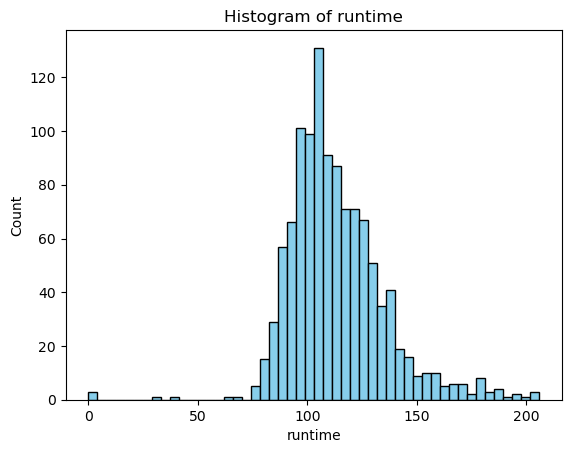

0.25     99.0
0.50    110.0
0.75    124.0
Name: Runtime, dtype: float64


In [22]:
runtime = movie_data[["title", "Runtime"]]

runtime.dropna(inplace=True)

runtime = runtime.reset_index(drop=True)

plt.hist(runtime["Runtime"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('runtime')
plt.ylabel('Count')
plt.title('Histogram of runtime')
plt.show()

print(runtime["Runtime"].quantile([0.25, 0.5, 0.75]))

In [23]:
bins = [0, 97, 111, 126, 300]
labels = ['Known Limits', 'Studio Mass Appeal', 'Director Clout', "A Long Movie"]
runtime['label'] = pd.cut(runtime['Runtime'], bins=bins, labels=labels, right=False)
runtime["label"].value_counts()

Studio Mass Appeal    348
Director Clout        290
A Long Movie          257
Known Limits          234
Name: label, dtype: int64

In [24]:
runtime['text'] = runtime['title'].apply(read_text_file)

runtime = runtime.drop(columns="Runtime")

runtime.head()

,title,label,text
0,10 Things I Hate About You,Studio Mass Appeal,TEN THINGS I HA...
1,12,Director Clout,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...
2,12 and Holding,Known Limits,\n \n \n ...
3,12 Monkeys,A Long Movie,TWELVE MONKEYS\n \n An orig...
4,12 Years a Slave,A Long Movie,12 YEARS A SLAVE\...


In [25]:
runtime_id2label = {0: 'Known Limits', 1: 'Studio Mass Appeal', 2: 'Director Clout', 3: "A Long Movie"}
runtime_label2id = {'Known Limits': 0, 'Studio Mass Appeal': 1, 'Director Clout': 2, "A Long Movie": 3}

runtime['label'] = runtime['label'].map(runtime_label2id)
runtime["label"] = runtime["label"].astype(int)

runtime = runtime.drop(columns="title")

In [26]:
runtime_dataset = Dataset.from_pandas(runtime) 
runtime_dataset = runtime_dataset.train_test_split(test_size=0.2)

In [27]:
tokenized_runtime = runtime_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/903 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

In [28]:
runtime_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=runtime_id2label, label2id=runtime_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
runtime_training_args = TrainingArguments(
    output_dir="runtime_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

runtime_trainer = Trainer(
    model=runtime_model,
    args=runtime_training_args,
    train_dataset=tokenized_runtime["train"],
    eval_dataset=tokenized_runtime["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

runtime_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.4038480520248413, 'eval_accuracy': 0.252212389380531, 'eval_runtime': 38.2601, 'eval_samples_per_second': 5.907, 'eval_steps_per_second': 0.392, 'epoch': 1.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.3919278383255005, 'eval_accuracy': 0.252212389380531, 'eval_runtime': 38.2193, 'eval_samples_per_second': 5.913, 'eval_steps_per_second': 0.392, 'epoch': 2.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.3920947313308716, 'eval_accuracy': 0.24778761061946902, 'eval_runtime': 38.5201, 'eval_samples_per_second': 5.867, 'eval_steps_per_second': 0.389, 'epoch': 3.0}
{'train_runtime': 1922.9213, 'train_samples_per_second': 1.409, 'train_steps_per_second': 0.089, 'train_loss': 1.3576090851722404, 'epoch': 3.0}


TrainOutput(global_step=171, training_loss=1.3576090851722404, metrics={'train_runtime': 1922.9213, 'train_samples_per_second': 1.409, 'train_steps_per_second': 0.089, 'train_loss': 1.3576090851722404, 'epoch': 3.0})

In [30]:
runtime_trainer.save_model()

# IMDB Score

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_62662/3056618376.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb.dropna(inplace=True)


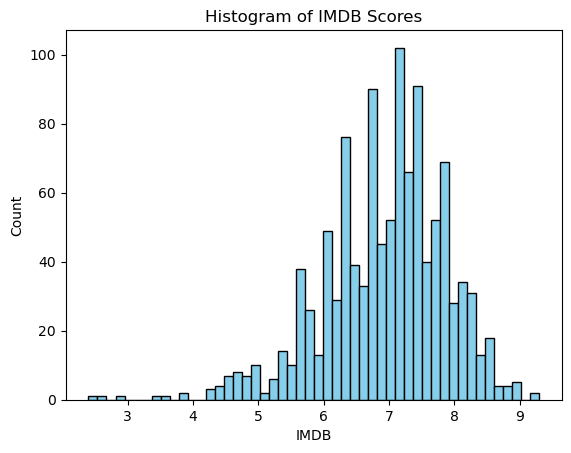

0.25    6.4
0.50    7.0
0.75    7.6
Name: IMDB, dtype: float64


In [31]:
imdb = movie_data[["title", "IMDB"]]

imdb.dropna(inplace=True)

imdb = imdb.reset_index(drop=True)

plt.hist(imdb["IMDB"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('IMDB')
plt.ylabel('Count')
plt.title('Histogram of IMDB Scores')
plt.show()

print(imdb["IMDB"].quantile([0.25, 0.5, 0.75]))

In [32]:
bins = [0, 6.1, 7.1, 8.1, 10.1]
labels = ['Bad', 'Alright', 'Good', "Amazing"]
imdb['label'] = pd.cut(imdb['IMDB'], bins=bins, labels=labels, right=False)
imdb["label"].value_counts()

Good       448
Alright    393
Bad        175
Amazing    111
Name: label, dtype: int64

In [33]:
imdb['text'] = imdb['title'].apply(read_text_file)

imdb = imdb.drop(columns="IMDB")

imdb.head()

,title,label,text
0,10 Things I Hate About You,Good,TEN THINGS I HA...
1,12,Good,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...
2,12 and Holding,Good,\n \n \n ...
3,12 Monkeys,Good,TWELVE MONKEYS\n \n An orig...
4,12 Years a Slave,Amazing,12 YEARS A SLAVE\...


In [34]:
imdb_id2label = {0: 'Bad', 1: 'Alright', 2: 'Good', 3: "Amazing"}
imdb_label2id = {'Bad': 0, 'Alright': 1, 'Good': 2, "Amazing": 3}

imdb['label'] = imdb['label'].map(imdb_label2id)
imdb["label"] = imdb["label"].astype(int)

imdb = imdb.drop(columns="title")

In [35]:
imdb_dataset = Dataset.from_pandas(imdb) 
imdb_dataset = imdb_dataset.train_test_split(test_size=0.2)

In [36]:
tokenized_imdb = imdb_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

In [37]:
imdb_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=imdb_id2label, label2id=imdb_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
imdb_training_args = TrainingArguments(
    output_dir="imdb_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

imdb_trainer = Trainer(
    model=imdb_model,
    args=imdb_training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

imdb_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.2325102090835571, 'eval_accuracy': 0.4336283185840708, 'eval_runtime': 38.6242, 'eval_samples_per_second': 5.851, 'eval_steps_per_second': 0.388, 'epoch': 1.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.23369300365448, 'eval_accuracy': 0.39823008849557523, 'eval_runtime': 38.4324, 'eval_samples_per_second': 5.88, 'eval_steps_per_second': 0.39, 'epoch': 2.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.2287787199020386, 'eval_accuracy': 0.4026548672566372, 'eval_runtime': 38.4376, 'eval_samples_per_second': 5.88, 'eval_steps_per_second': 0.39, 'epoch': 3.0}
{'train_runtime': 1916.7105, 'train_samples_per_second': 1.41, 'train_steps_per_second': 0.089, 'train_loss': 1.2504312615645559, 'epoch': 3.0}


TrainOutput(global_step=171, training_loss=1.2504312615645559, metrics={'train_runtime': 1916.7105, 'train_samples_per_second': 1.41, 'train_steps_per_second': 0.089, 'train_loss': 1.2504312615645559, 'epoch': 3.0})

In [39]:
imdb_trainer.save_model()

# Rotten Tomatoes Score

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_62662/2428160918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt.dropna(inplace=True)


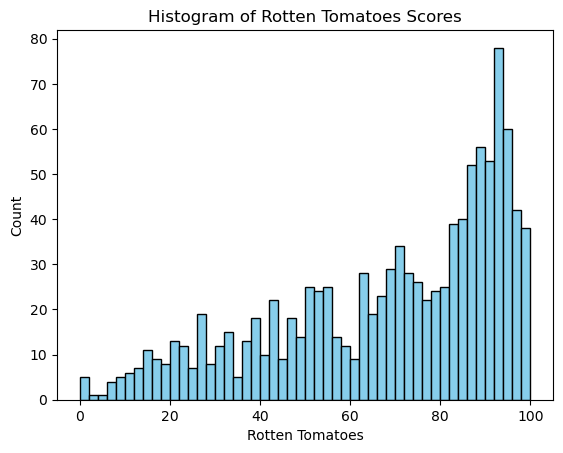

0.25    51.0
0.50    75.0
0.75    90.0
Name: Rotten_Tomatoes, dtype: float64


In [40]:
rt = movie_data[["title", "Rotten_Tomatoes"]]

rt.dropna(inplace=True)

rt = rt.reset_index(drop=True)

plt.hist(rt["Rotten_Tomatoes"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Rotten Tomatoes')
plt.ylabel('Count')
plt.title('Histogram of Rotten Tomatoes Scores')
plt.show()

print(rt["Rotten_Tomatoes"].quantile([0.25, 0.5, 0.75]))

In [41]:
bins = [0, 51, 76, 91, 101]
labels = ['Bad', 'Alright', 'Good', "Amazing"]
rt['label'] = pd.cut(rt['Rotten_Tomatoes'], bins=bins, labels=labels, right=False)
rt["label"].value_counts()

Alright    280
Good       275
Bad        268
Amazing    254
Name: label, dtype: int64

In [42]:
rt['text'] = rt['title'].apply(read_text_file)

rt = rt.drop(columns="Rotten_Tomatoes")

rt.head()

,title,label,text
0,10 Things I Hate About You,Alright,TEN THINGS I HA...
1,12 and Holding,Alright,\n \n \n ...
2,12 Monkeys,Good,TWELVE MONKEYS\n \n An orig...
3,12 Years a Slave,Amazing,12 YEARS A SLAVE\...
4,127 Hours,Amazing,\n 127 HOUR...


In [43]:
rt_id2label = {0: 'Bad', 1: 'Alright', 2: 'Good', 3: "Amazing"}
rt_label2id = {'Bad': 0, 'Alright': 1, 'Good': 2, "Amazing": 3}

rt['label'] = rt['label'].map(rt_label2id)
rt["label"] = rt["label"].astype(int)

rt = rt.drop(columns="title")

In [44]:
rt_dataset = Dataset.from_pandas(rt) 
rt_dataset = rt_dataset.train_test_split(test_size=0.2)

In [45]:
tokenized_rt = rt_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/861 [00:00<?, ? examples/s]

Map:   0%|          | 0/216 [00:00<?, ? examples/s]

In [46]:
rt_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=rt_id2label, label2id=rt_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
rt_training_args = TrainingArguments(
    output_dir="rt_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

rt_trainer = Trainer(
    model=rt_model,
    args=rt_training_args,
    train_dataset=tokenized_rt["train"],
    eval_dataset=tokenized_rt["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

rt_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.3845793008804321, 'eval_accuracy': 0.24537037037037038, 'eval_runtime': 36.9785, 'eval_samples_per_second': 5.841, 'eval_steps_per_second': 0.379, 'epoch': 1.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.376907229423523, 'eval_accuracy': 0.2962962962962963, 'eval_runtime': 36.723, 'eval_samples_per_second': 5.882, 'eval_steps_per_second': 0.381, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 1.3660895824432373, 'eval_accuracy': 0.3148148148148148, 'eval_runtime': 36.5413, 'eval_samples_per_second': 5.911, 'eval_steps_per_second': 0.383, 'epoch': 3.0}
{'train_runtime': 1829.0936, 'train_samples_per_second': 1.412, 'train_steps_per_second': 0.089, 'train_loss': 1.3719334543487172, 'epoch': 3.0}


TrainOutput(global_step=162, training_loss=1.3719334543487172, metrics={'train_runtime': 1829.0936, 'train_samples_per_second': 1.412, 'train_steps_per_second': 0.089, 'train_loss': 1.3719334543487172, 'epoch': 3.0})

In [48]:
rt_trainer.save_model()

# Metacritic Score

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_62662/1890454646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metascore.dropna(inplace=True)


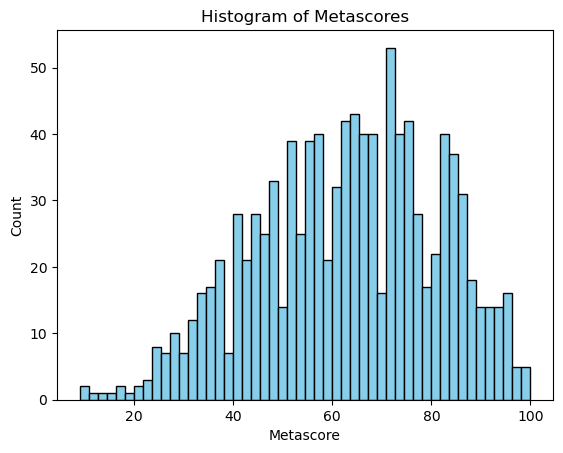

0.25    50.0
0.50    64.0
0.75    77.0
Name: Metascore, dtype: float64


In [49]:
metascore = movie_data[["title", "Metascore"]]

metascore.dropna(inplace=True)

metascore = metascore.reset_index(drop=True)

plt.hist(metascore["Metascore"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Metascore')
plt.ylabel('Count')
plt.title('Histogram of Metascores')
plt.show()

print(metascore["Metascore"].quantile([0.25, 0.5, 0.75]))

In [50]:
bins = [0, 51, 66, 76, 101]
labels = ['Bad', 'Alright', 'Good', "Amazing"]
metascore['label'] = pd.cut(metascore['Metascore'], bins=bins, labels=labels, right=False)
metascore["label"].value_counts()

Amazing    285
Alright    281
Bad        267
Good       207
Name: label, dtype: int64

In [51]:
metascore['text'] = metascore['title'].apply(read_text_file)

metascore = metascore.drop(columns="Metascore")

metascore.head()

,title,label,text
0,10 Things I Hate About You,Good,TEN THINGS I HA...
1,12 and Holding,Alright,\n \n \n ...
2,12 Monkeys,Good,TWELVE MONKEYS\n \n An orig...
3,12 Years a Slave,Amazing,12 YEARS A SLAVE\...
4,127 Hours,Amazing,\n 127 HOUR...


In [52]:
metascore_id2label = {0: 'Bad', 1: 'Alright', 2: 'Good', 3: "Amazing"}
metascore_label2id = {'Bad': 0, 'Alright': 1, 'Good': 2, "Amazing": 3}

metascore['label'] = metascore['label'].map(metascore_label2id)
metascore["label"] = metascore["label"].astype(int)

metascore = metascore.drop(columns="title")

In [53]:
metascore_dataset = Dataset.from_pandas(metascore) 
metascore_dataset = metascore_dataset.train_test_split(test_size=0.2)

In [54]:
tokenized_metascore = metascore_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

In [55]:
metascore_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=metascore_id2label, label2id=metascore_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
metascore_training_args = TrainingArguments(
    output_dir="metascore_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

metascore_trainer = Trainer(
    model=metascore_model,
    args=metascore_training_args,
    train_dataset=tokenized_metascore["train"],
    eval_dataset=tokenized_metascore["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

metascore_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.3794198036193848, 'eval_accuracy': 0.2932692307692308, 'eval_runtime': 34.8661, 'eval_samples_per_second': 5.966, 'eval_steps_per_second': 0.373, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.3724623918533325, 'eval_accuracy': 0.34134615384615385, 'eval_runtime': 34.9458, 'eval_samples_per_second': 5.952, 'eval_steps_per_second': 0.372, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.3663970232009888, 'eval_accuracy': 0.30288461538461536, 'eval_runtime': 35.0354, 'eval_samples_per_second': 5.937, 'eval_steps_per_second': 0.371, 'epoch': 3.0}
{'train_runtime': 1754.2111, 'train_samples_per_second': 1.423, 'train_steps_per_second': 0.089, 'train_loss': 1.3559379577636719, 'epoch': 3.0}


TrainOutput(global_step=156, training_loss=1.3559379577636719, metrics={'train_runtime': 1754.2111, 'train_samples_per_second': 1.423, 'train_steps_per_second': 0.089, 'train_loss': 1.3559379577636719, 'epoch': 3.0})

In [57]:
metascore_trainer.save_model()

# Boxoffice

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_62662/1009520661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxoffice.dropna(inplace=True)


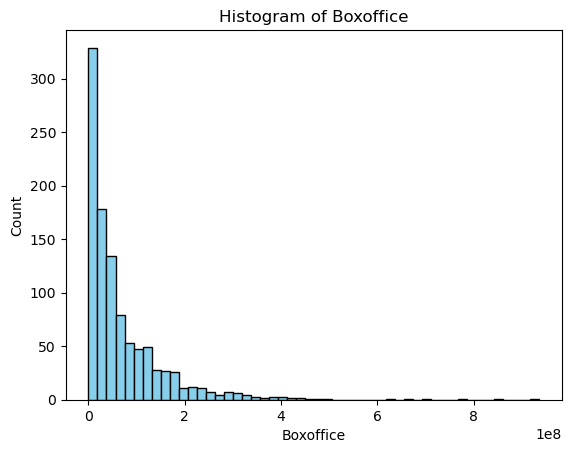

0.25    13604528.5
0.50    38311312.5
0.75    94879129.0
Name: Boxoffice, dtype: float64


In [58]:
boxoffice = movie_data[["title", "Boxoffice"]]

boxoffice.dropna(inplace=True)

boxoffice = boxoffice.reset_index(drop=True)

plt.hist(boxoffice["Boxoffice"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Boxoffice')
plt.ylabel('Count')
plt.title('Histogram of Boxoffice')
plt.show()

print(boxoffice["Boxoffice"].quantile([0.25, 0.5, 0.75]))

In [59]:
bins = [0, 10000000, 40000000, 100000000, 999999999999999]
labels = ['Not Much', 'Indie Loved', 'Great Showout', 'Blockbuster']
boxoffice['label'] = pd.cut(boxoffice['Boxoffice'], bins=bins, labels=labels, right=False)
boxoffice["label"].value_counts()

Indie Loved      322
Great Showout    258
Blockbuster      246
Not Much         210
Name: label, dtype: int64

In [60]:
boxoffice['text'] = boxoffice['title'].apply(read_text_file)

boxoffice = boxoffice.drop(columns="Boxoffice")

boxoffice.head()

,title,label,text
0,10 Things I Hate About You,Indie Loved,TEN THINGS I HA...
1,12 and Holding,Not Much,\n \n \n ...
2,12 Monkeys,Great Showout,TWELVE MONKEYS\n \n An orig...
3,12 Years a Slave,Great Showout,12 YEARS A SLAVE\...
4,127 Hours,Indie Loved,\n 127 HOUR...


In [61]:
boxoffice_id2label = {0: 'Not Much', 1: 'Indie Loved', 2: 'Great Showout', 3: 'Blockbuster'}
boxoffice_label2id = {'Not Much': 0, 'Indie Loved': 1, 'Great Showout': 2, 'Blockbuster': 3}

boxoffice['label'] = boxoffice['label'].map(boxoffice_label2id)
boxoffice["label"] = boxoffice["label"].astype(int)

boxoffice = boxoffice.drop(columns="title")

In [62]:
boxoffice_dataset = Dataset.from_pandas(boxoffice) 
boxoffice_dataset = boxoffice_dataset.train_test_split(test_size=0.2)

In [63]:
tokenized_boxoffice = boxoffice_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

In [64]:
boxoffice_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=boxoffice_id2label, label2id=boxoffice_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
boxoffice_training_args = TrainingArguments(
    output_dir="boxoffice_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

boxoffice_trainer = Trainer(
    model=boxoffice_model,
    args=boxoffice_training_args,
    train_dataset=tokenized_boxoffice["train"],
    eval_dataset=tokenized_boxoffice["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

boxoffice_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.3740160465240479, 'eval_accuracy': 0.27884615384615385, 'eval_runtime': 34.7561, 'eval_samples_per_second': 5.985, 'eval_steps_per_second': 0.374, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.3445299863815308, 'eval_accuracy': 0.33653846153846156, 'eval_runtime': 34.642, 'eval_samples_per_second': 6.004, 'eval_steps_per_second': 0.375, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.336427927017212, 'eval_accuracy': 0.34615384615384615, 'eval_runtime': 34.8254, 'eval_samples_per_second': 5.973, 'eval_steps_per_second': 0.373, 'epoch': 3.0}
{'train_runtime': 1737.3543, 'train_samples_per_second': 1.43, 'train_steps_per_second': 0.09, 'train_loss': 1.3529854798928285, 'epoch': 3.0}


TrainOutput(global_step=156, training_loss=1.3529854798928285, metrics={'train_runtime': 1737.3543, 'train_samples_per_second': 1.43, 'train_steps_per_second': 0.09, 'train_loss': 1.3529854798928285, 'epoch': 3.0})

In [66]:
boxoffice_trainer.save_model()

# Season of Year

In [67]:
season = movie_data[["title", "Season"]]

season.dropna(inplace=True)

season = season.reset_index(drop=True)

season["Season"] = season["Season"].astype(int)
season["Season"] = season["Season"] - 1

season["Season"].value_counts()
season.rename(columns={'Season': 'label'}, inplace=True)

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_62662/1996086055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season.dropna(inplace=True)


In [68]:
season['text'] = season['title'].apply(read_text_file)

season.head()

,title,label,text
0,10 Things I Hate About You,1,TEN THINGS I HA...
1,12,2,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...
2,12 and Holding,2,\n \n \n ...
3,12 Monkeys,0,TWELVE MONKEYS\n \n An orig...
4,12 Years a Slave,3,12 YEARS A SLAVE\...


In [69]:
season_id2label = {0: 'Jan-Mar', 1: 'Apr-Jun', 2: 'Jul-Sep', 3: "Oct-Dec"}
season_label2id = {'Jan-Mar': 0, 'Apr-Jun': 1, 'Jul-Sep': 2, "Oct-Dec": 3}

season = season.drop(columns="title")

In [70]:
season_dataset = Dataset.from_pandas(season) 
season_dataset = season_dataset.train_test_split(test_size=0.2)

In [71]:
tokenized_season = season_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/899 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

In [72]:
season_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=season_id2label, label2id=season_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
season_training_args = TrainingArguments(
    output_dir="season_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

season_trainer = Trainer(
    model=season_model,
    args=season_training_args,
    train_dataset=tokenized_season["train"],
    eval_dataset=tokenized_season["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

season_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.386296272277832, 'eval_accuracy': 0.24444444444444444, 'eval_runtime': 37.7395, 'eval_samples_per_second': 5.962, 'eval_steps_per_second': 0.397, 'epoch': 1.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.3787847757339478, 'eval_accuracy': 0.28444444444444444, 'eval_runtime': 37.5417, 'eval_samples_per_second': 5.993, 'eval_steps_per_second': 0.4, 'epoch': 2.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 1.3749665021896362, 'eval_accuracy': 0.3111111111111111, 'eval_runtime': 37.1787, 'eval_samples_per_second': 6.052, 'eval_steps_per_second': 0.403, 'epoch': 3.0}
{'train_runtime': 1877.2076, 'train_samples_per_second': 1.437, 'train_steps_per_second': 0.091, 'train_loss': 1.3739906891047606, 'epoch': 3.0}


TrainOutput(global_step=171, training_loss=1.3739906891047606, metrics={'train_runtime': 1877.2076, 'train_samples_per_second': 1.437, 'train_steps_per_second': 0.091, 'train_loss': 1.3739906891047606, 'epoch': 3.0})

In [74]:
season_trainer.save_model()

# Award Wins

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_62662/143981010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wins.dropna(inplace=True)


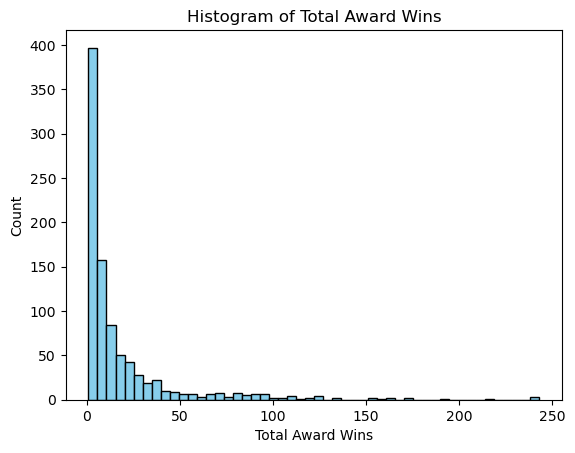

0.25     3.0
0.50     7.0
0.75    19.0
Name: Total_Wins, dtype: float64


In [75]:
wins = movie_data[["title", "Total_Wins"]]

wins.dropna(inplace=True)

wins = wins.reset_index(drop=True)

plt.hist(wins["Total_Wins"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Total Award Wins')
plt.ylabel('Count')
plt.title('Histogram of Total Award Wins')
plt.show()

print(wins["Total_Wins"].quantile([0.25, 0.5, 0.75]))

In [76]:
bins = [0, 2, 8, 20, 500]
labels = ['None', 'A Few', 'Awards Buzz', 'Acclaimed']
wins['label'] = pd.cut(wins['Total_Wins'], bins=bins, labels=labels, right=False)
wins["label"].value_counts()

A Few          341
Acclaimed      227
Awards Buzz    213
None           128
Name: label, dtype: int64

In [77]:
wins['text'] = wins['title'].apply(read_text_file)

wins = wins.drop(columns="Total_Wins")

wins.head()

,title,label,text
0,10 Things I Hate About You,A Few,TEN THINGS I HA...
1,12,A Few,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...
2,12 Monkeys,Awards Buzz,TWELVE MONKEYS\n \n An orig...
3,12 Years a Slave,Acclaimed,12 YEARS A SLAVE\...
4,127 Hours,Acclaimed,\n 127 HOUR...


In [78]:
wins_id2label = {0: 'None', 1: 'A Few', 2: 'Awards Buzz', 3: 'Acclaimed'}
wins_label2id = {'None': 0, 'A Few': 1, 'Awards Buzz': 2, 'Acclaimed': 3}

wins['label'] = wins['label'].map(wins_label2id)
wins["label"] = wins["label"].astype(int)

wins = wins.drop(columns="title")

In [79]:
wins_dataset = Dataset.from_pandas(wins) 
wins_dataset = wins_dataset.train_test_split(test_size=0.2)

In [80]:
tokenized_wins = wins_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/727 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

In [81]:
wins_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=wins_id2label, label2id=wins_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
wins_training_args = TrainingArguments(
    output_dir="wins_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

wins_trainer = Trainer(
    model=wins_model,
    args=wins_training_args,
    train_dataset=tokenized_wins["train"],
    eval_dataset=tokenized_wins["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

wins_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 1.3118215799331665, 'eval_accuracy': 0.41208791208791207, 'eval_runtime': 29.5744, 'eval_samples_per_second': 6.154, 'eval_steps_per_second': 0.406, 'epoch': 1.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 1.3148472309112549, 'eval_accuracy': 0.41208791208791207, 'eval_runtime': 29.9787, 'eval_samples_per_second': 6.071, 'eval_steps_per_second': 0.4, 'epoch': 2.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 1.3097574710845947, 'eval_accuracy': 0.4175824175824176, 'eval_runtime': 29.3687, 'eval_samples_per_second': 6.197, 'eval_steps_per_second': 0.409, 'epoch': 3.0}
{'train_runtime': 1496.109, 'train_samples_per_second': 1.458, 'train_steps_per_second': 0.092, 'train_loss': 1.3214762590933538, 'epoch': 3.0}


TrainOutput(global_step=138, training_loss=1.3214762590933538, metrics={'train_runtime': 1496.109, 'train_samples_per_second': 1.458, 'train_steps_per_second': 0.092, 'train_loss': 1.3214762590933538, 'epoch': 3.0})

In [83]:
wins_trainer.save_model()

# Award Noms

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_62662/4055031838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominations.dropna(inplace=True)


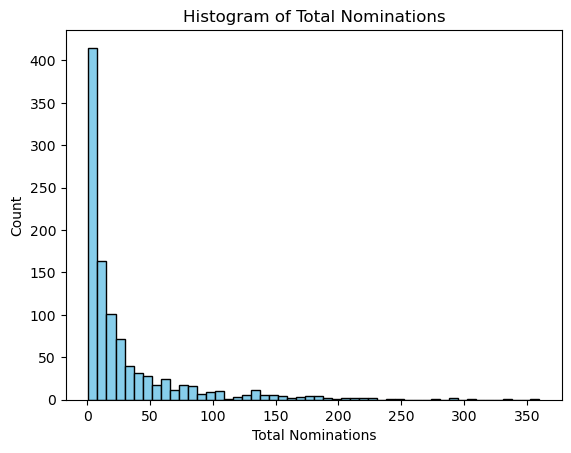

0.25     5.0
0.50    12.0
0.75    33.0
Name: Total_Noms, dtype: float64


In [84]:
nominations = movie_data[["title", "Total_Noms"]]

nominations.dropna(inplace=True)

nominations = nominations.reset_index(drop=True)

plt.hist(nominations["Total_Noms"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Total Nominations')
plt.ylabel('Count')
plt.title('Histogram of Total Nominations')
plt.show()

print(nominations["Total_Noms"].quantile([0.25, 0.5, 0.75]))

In [85]:
bins = [0, 4, 14, 40, 1000]
labels = ['None', 'A Few', 'Awards Buzz', 'Acclaimed']
nominations['label'] = pd.cut(nominations['Total_Noms'], bins=bins, labels=labels, right=False)
nominations["label"].value_counts()

A Few          337
Awards Buzz    267
Acclaimed      221
None           202
Name: label, dtype: int64

In [86]:
nominations['text'] = nominations['title'].apply(read_text_file)

nominations = nominations.drop(columns="Total_Noms")

nominations.head()

,title,label,text
0,10 Things I Hate About You,A Few,TEN THINGS I HA...
1,12 and Holding,A Few,\n \n \n ...
2,12 Monkeys,Awards Buzz,TWELVE MONKEYS\n \n An orig...
3,12 Years a Slave,Acclaimed,12 YEARS A SLAVE\...
4,127 Hours,Acclaimed,\n 127 HOUR...


In [87]:
nominations_id2label = {0: 'None', 1: 'A Few', 2: 'Awards Buzz', 3: 'Acclaimed'}
nominations_label2id = {'None': 0, 'A Few': 1, 'Awards Buzz': 2, 'Acclaimed': 3}

nominations['label'] = nominations['label'].map(nominations_label2id)
nominations["label"] = nominations["label"].astype(int)

nominations = nominations.drop(columns="title")

In [88]:
nominations_dataset = Dataset.from_pandas(nominations) 
nominations_dataset = nominations_dataset.train_test_split(test_size=0.2)

In [89]:
tokenized_nominations = nominations_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/821 [00:00<?, ? examples/s]

Map:   0%|          | 0/206 [00:00<?, ? examples/s]

In [90]:
nominations_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=nominations_id2label, label2id=nominations_label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
nominations_training_args = TrainingArguments(
    output_dir="nominations_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

nominations_trainer = Trainer(
    model=nominations_model,
    args=nominations_training_args,
    train_dataset=tokenized_nominations["train"],
    eval_dataset=tokenized_nominations["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

nominations_trainer.train()

/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.3656975030899048, 'eval_accuracy': 0.32524271844660196, 'eval_runtime': 34.1353, 'eval_samples_per_second': 6.035, 'eval_steps_per_second': 0.381, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.3579133749008179, 'eval_accuracy': 0.32524271844660196, 'eval_runtime': 33.6983, 'eval_samples_per_second': 6.113, 'eval_steps_per_second': 0.386, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.356183648109436, 'eval_accuracy': 0.3300970873786408, 'eval_runtime': 33.85, 'eval_samples_per_second': 6.086, 'eval_steps_per_second': 0.384, 'epoch': 3.0}
{'train_runtime': 1694.381, 'train_samples_per_second': 1.454, 'train_steps_per_second': 0.092, 'train_loss': 1.3532928075545874, 'epoch': 3.0}


TrainOutput(global_step=156, training_loss=1.3532928075545874, metrics={'train_runtime': 1694.381, 'train_samples_per_second': 1.454, 'train_steps_per_second': 0.092, 'train_loss': 1.3532928075545874, 'epoch': 3.0})

In [92]:
nominations_trainer.save_model()

# Genres - multilabel text classification

In [93]:
genres = movie_data[["title", "Genre"]]

genre_labels = genres['Genre'].str.split(', ', expand=True)
genre_labels.columns = [f'label {i}' for i in range(1, genre_labels.shape[1] + 1)]

genres = pd.concat([genres, genre_labels], axis=1).drop(columns = 'Genre')

genres["all_labels"] = genres.apply(lambda row: [label for label in row[1:] if label is not None], axis=1)

In [94]:
genres_unique_labels = genres[['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']].stack().unique()

genres_class2id = {genre: idx for idx, genre in enumerate(genres_unique_labels)}
genres_id2class = {idx: genre for genre, idx in genres_class2id.items()}
genres_classes = list(genres_id2class.values())

In [95]:
columns_to_replace = [col for col in genres.columns if col != 'title' and col != 'all_labels']

genres[columns_to_replace] = genres[columns_to_replace].replace(genres_class2id)

In [96]:
genres[columns_to_replace] = genres[columns_to_replace].astype('Int64')

genres.replace({np.nan: None}, inplace=True)

In [97]:
genres['content'] = genres['title'].apply(read_text_file)

genres.head()

,title,label 1,label 2,label 3,label 4,label 5,label 6,label 7,all_labels,content
0,10 Things I Hate About You,0,1,2,None,None,None,None,"[Comedy, Drama, Romance]",TEN THINGS I HA...
1,12,0,3,None,None,None,None,None,"[Comedy, Music]",\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...
2,12 and Holding,1,None,None,None,None,None,None,[Drama],\n \n \n ...
3,12 Monkeys,4,5,6,None,None,None,None,"[Mystery, Sci-Fi, Thriller]",TWELVE MONKEYS\n \n An orig...
4,12 Years a Slave,7,1,8,None,None,None,None,"[Biography, Drama, History]",12 YEARS A SLAVE\...


In [98]:
genres_dataset = Dataset.from_pandas(genres) 
genres_dataset = genres_dataset.train_test_split(test_size=0.2)

In [99]:
def genres_preprocess_function(example):
   text = f"{example['title']}.\n{example['content']}"
   all_labels = example['all_labels']
   labels = [0. for i in range(len(genres_classes))]
   for label in all_labels:
       label_id = genres_class2id[label]
       labels[label_id] = 1.
  
   example = tokenizer(text, truncation=True)
   example['labels'] = labels
   return example

tokenized_genres = genres_dataset.map(genres_preprocess_function)


Map:   0%|          | 0/903 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

In [100]:
genres_clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def genres_compute_metrics(eval_pred):

   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return genres_clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))

In [101]:
genres_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(genres_classes), id2label=genres_id2class, label2id=genres_class2id,
    problem_type = "multi_label_classification")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
genres_training_args = TrainingArguments(
    output_dir="genres_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

genres_trainer = Trainer(
    model=genres_model,
    args=genres_training_args,
    train_dataset=tokenized_genres["train"],
    eval_dataset=tokenized_genres["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=genres_compute_metrics,
)

genres_trainer.train()


/Users/carson/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.3717917501926422, 'eval_accuracy': 0.8897827835880934, 'eval_f1': 0.3234567901234568, 'eval_precision': 0.5796460176991151, 'eval_recall': 0.2243150684931507, 'eval_runtime': 36.543, 'eval_samples_per_second': 6.184, 'eval_steps_per_second': 0.41, 'epoch': 1.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.32666975259780884, 'eval_accuracy': 0.8897827835880934, 'eval_f1': 0.3234567901234568, 'eval_precision': 0.5796460176991151, 'eval_recall': 0.2243150684931507, 'eval_runtime': 37.0509, 'eval_samples_per_second': 6.1, 'eval_steps_per_second': 0.405, 'epoch': 2.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.3173934519290924, 'eval_accuracy': 0.8897827835880934, 'eval_f1': 0.3234567901234568, 'eval_precision': 0.5796460176991151, 'eval_recall': 0.2243150684931507, 'eval_runtime': 36.7596, 'eval_samples_per_second': 6.148, 'eval_steps_per_second': 0.408, 'epoch': 3.0}
{'train_runtime': 1844.6302, 'train_samples_per_second': 1.469, 'train_steps_per_second': 0.093, 'train_loss': 0.3858503375137061, 'epoch': 3.0}


TrainOutput(global_step=171, training_loss=0.3858503375137061, metrics={'train_runtime': 1844.6302, 'train_samples_per_second': 1.469, 'train_steps_per_second': 0.093, 'train_loss': 0.3858503375137061, 'epoch': 3.0})

In [103]:
genres_trainer.save_model()

SafetensorError: Error while serializing: IoError(Os { code: 28, kind: StorageFull, message: "No space left on device" })

# Country - multilabel text classification

In [ ]:
countries = movie_data[["title", "Country"]]

countries.dropna(inplace=True)
countries = countries.reset_index(drop=True)

country_labels = countries['Country'].str.split(', ', expand=True)
country_labels.columns = [f'label {i}' for i in range(1, country_labels.shape[1] + 1)]

countries = pd.concat([countries, country_labels], axis=1).drop(columns = 'Country')

countries["all_labels"] = countries.apply(lambda row: [label for label in row[1:] if label is not None], axis=1)

In [ ]:
countries_unique_labels = countries[['label 1', 'label 2', 'label 3', 'label 4', 'label 5', 'label 6', 'label 7']].stack().unique()

countries_class2id = {country: idx for idx, country in enumerate(countries_unique_labels)}
countries_id2class = {idx: country for country, idx in countries_class2id.items()}
countries_classes = list(countries_id2class.values())

In [ ]:
columns_to_replace = [col for col in countries.columns if col != 'title' and col != 'all_labels']

countries[columns_to_replace] = countries[columns_to_replace].replace(countries_class2id)

In [ ]:
countries[columns_to_replace] = countries[columns_to_replace].astype('Int64')

countries.replace({np.nan: None}, inplace=True)

In [ ]:
countries['content'] = countries['title'].apply(read_text_file)

countries.head()

In [ ]:
countries_dataset = Dataset.from_pandas(countries) 
countries_dataset = countries_dataset.train_test_split(test_size=0.2)

In [ ]:
def countries_preprocess_function(example):
   text = f"{example['title']}.\n{example['content']}"
   all_labels = example['all_labels']
   labels = [0. for i in range(len(countries_classes))]
   for label in all_labels:
       label_id = countries_class2id[label]
       labels[label_id] = 1.
  
   example = tokenizer(text, truncation=True)
   example['labels'] = labels
   return example

tokenized_countries = countries_dataset.map(countries_preprocess_function)

In [ ]:
countries_clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def countries_compute_metrics(eval_pred):

   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return countries_clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))

In [ ]:
countries_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(countries_classes), id2label=countries_id2class, label2id=countries_class2id,
    problem_type = "multi_label_classification")


In [ ]:
countries_training_args = TrainingArguments(
    output_dir="countries_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="no"
)

countries_trainer = Trainer(
    model=countries_model,
    args=countries_training_args,
    train_dataset=tokenized_countries["train"],
    eval_dataset=tokenized_countries["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=countries_compute_metrics,
)

countries_trainer.train()


In [ ]:
countries_trainer.save_model()

# Predict On One Example

In [104]:
from transformers import TextClassificationPipeline, AutoTokenizer, AutoModelForSequenceClassification

with open('Scripts/Inglourious Basterds.txt', 'r') as file:
    ib = file.read()

print(ib)

 
          

                                 INGLOURIOUS BASTERDS

          

          
                                      Written by
          
                                   Quentin Tarantino

          

          

          1.

          EXT - DAIRY FARM- DAY
          The modest dairy farm in the countryside of Nancy, France (what the
          French call cow country).
          We Read a SUBTITLE in the sky above the farm house;

          CHAPTER ONE

          "ONCE UPON A TIME IN...

          NAZI OCCUPIED FRANCE"
          This SUBTITLE disappears, and is replaced by another one;

          "1941
          One year into the German
          occupation of France".
          The farm consists of a house, small barn, and twelve cows spread
          about.
          The owner of the property, a bull of a man FRENCH FARMER, brings a axe
          up and down on A tree stump blemishing his property. However simply by
          sight, you'd never know if he's been bea

In [105]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [106]:
model_names = ["ratings_model", "eras_model", "runtime_model", 
                "imdb_model", "rt_model", "metascore_model",
                "boxoffice_model", "season_model",
                "wins_model", "nominations_model",]
                 #"genres_model", "countries_model"]

In [107]:
for i in range(len(model_names)):
    trained_model = AutoModelForSequenceClassification.from_pretrained(model_names[i])
    pipe = TextClassificationPipeline(model=trained_model, tokenizer=tokenizer, truncation=True)
    predictions = pipe(ib, return_all_scores=True)
    sorted_predictions = sorted(predictions[0], key=lambda x: x['score'], reverse=True)

    print(model_names[i])
    for prediction in sorted_predictions:
        rounded_score = round(prediction['score'] * 100, 1)
        print(f"{prediction['label']} : {rounded_score}%")
    print("")

/Users/carson/anaconda3/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


ratings_model
R : 61.6%
PG-13 : 23.6%
PG : 12.0%
G : 2.7%

eras_model
New Millennium : 48.0%
Dawn of Modern Film : 40.5%
The Changes : 6.1%
Talkies : 2.8%
Golden Era : 2.6%

runtime_model
Studio Mass Appeal : 31.8%
Director Clout : 26.9%
A Long Movie : 23.0%
Known Limits : 18.3%

imdb_model
Good : 45.2%
Alright : 31.5%
Bad : 12.7%
Amazing : 10.6%

rt_model
Amazing : 27.7%
Good : 25.6%
Alright : 24.7%
Bad : 21.9%

metascore_model
Amazing : 36.3%
Alright : 24.1%
Bad : 20.0%
Good : 19.6%

boxoffice_model
Indie Loved : 33.3%
Not Much : 26.2%
Great Showout : 20.9%
Blockbuster : 19.6%

season_model
Jan-Mar : 27.3%
Oct-Dec : 27.1%
Jul-Sep : 24.3%
Apr-Jun : 21.4%

wins_model
A Few : 33.0%
Acclaimed : 28.9%
Awards Buzz : 24.5%
None : 13.5%

nominations_model
A Few : 32.2%
Acclaimed : 24.6%
Awards Buzz : 23.5%
None : 19.6%



# Sources Used:

Modeling: 

Fine tuning tutorial - https://huggingface.co/docs/transformers/v4.17.0/en/tasks/sequence_classification

Pretrained model - https://huggingface.co/distilbert/distilbert-base-uncased

Multi-label classification tutorial: https://huggingface.co/blog/Valerii-Knowledgator/multi-label-classification

Data:

OMDB - https://omdbapi.com/

IMDB - https://www.imdb.com/

Metascore - https://www.metacritic.com/

Rotten Tomatoes - https://www.rottentomatoes.com/

Screenplays - https://imsdb.com/

Movie Eras - http://www.historyoffilm.net/movie-eras/history-of-cinema/
